In [2]:
%load_ext autoreload
%autoreload 2
# Add parent directory into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

In [3]:
import torch
from torch import nn
from torch.nn.init import calculate_gain
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f'CUDA {i}: {torch.cuda.get_device_name(i)}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)

CUDA 0: NVIDIA GeForce GTX 1650 Ti


In [4]:
from models import MLP_PINN
net = MLP_PINN(N_layers=8, width=32, loss_lambda=(1.0, 1.0, 0.0), activation=nn.ELU()).to(device)

In [5]:
import os
from utils.dataset import ImplicitDataset

dataset_name = '../datasets/box_1.0_10K_1M'
output_stl = dataset_name+'.stl'
train_dataset = ImplicitDataset.from_file(file=dataset_name+'_train.npz', device=device)
print(train_dataset)

Implicit dataset (15344 PDE points, 4384 Dirichlet BCs)
MeshSDFDataset (1000000 points)


In [7]:
from utils.optimizer import CallbackScheduler

# Optimization
## ADA
optimizer=torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-6, amsgrad=False)
lr_scheduler = CallbackScheduler([
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.init_LBFGS(
        lr=1, max_iter=20, max_eval=40, 
        tolerance_grad=1e-5, tolerance_change=1e-9,
        history_size=100,
        line_search_fn=None
    ),
    CallbackScheduler.reduce_lr(0.2)
], optimizer=optimizer, model=net, eps=1e-7, patience=300)

In [8]:
max_epochs = 2500
PRINT_EVERY_EPOCH = 100
try:
    for epoch in range(max_epochs):
        # Training
        optimizer.zero_grad()
        loss = net.loss(train_dataset.pde_points, train_dataset.bc_points, train_dataset.bc_sdfs)
        loss.backward()
      
        lr_scheduler.optimizer.step(lambda: loss)
        lr_scheduler.step_when((epoch % 500) == 499)
        lr_scheduler.step_loss(loss)                

        if epoch % PRINT_EVERY_EPOCH == 0:
            print(f'#{epoch} Loss: {net._loss_PDE:.6f}, {net._loss_SDF:.6f}')

            if device.type == 'cuda':
                torch.cuda.empty_cache()
        
except KeyboardInterrupt as e:
    print('Bye bye')


#0 Loss: 0.615464, 0.326671
#100 Loss: 0.017562, 0.005731
#200 Loss: 0.009584, 0.003374
#300 Loss: 0.006352, 0.002161
#400 Loss: 0.004978, 0.001650
#500 Loss: 0.004170, 0.001434
#600 Loss: 0.004036, 0.001400
Bye bye


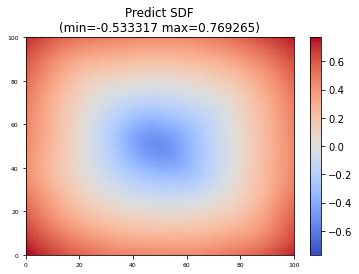

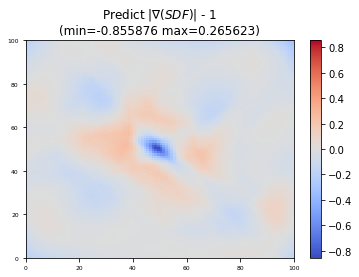

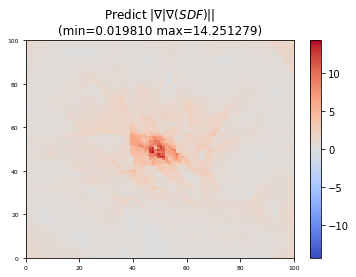

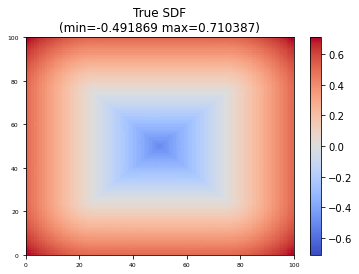

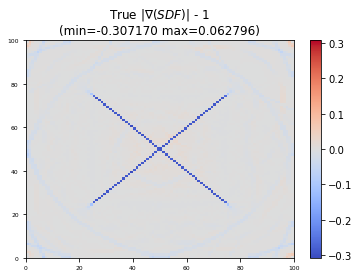

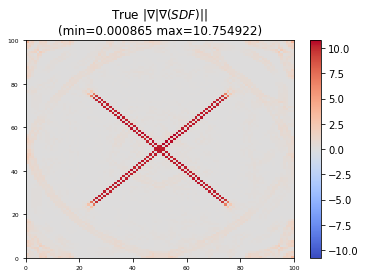

In [9]:
from utils import SDFVisualize, plot_model_weight
visualize = SDFVisualize(z_level=0, step=0.05, offset=30, nums=100)
visualize.from_nn(net, bounds_from_mesh=output_stl, device=device, plot_gradient=True)
visualize.from_mesh(output_stl, plot_gradient=True)